# Adadelta
- Adadelta 算是 Adagrad 法的延伸，它跟 RMSProp 一样，都是为了解决 Adagrad 中**学习率减小过快**的问题.
- RMSProp 是通过移动加权平均(缩放梯度平方)的方式，而 Adadelta 也是一种方法，有趣的是，**它并不需要学习率这个参数**。
- RMSProp 是对分母进行的优化,分子上的原始学习率是固定的; 
- Adadelta是在RMSProp的基础上又对分子进行了优化,不再是固定的 $\eta$(eta), 而是逐渐变大的累加式变量 $\Delta \theta$


### RMSProp公式:
$$
\theta_{i+1} = \theta_i- \frac{\eta}{\sqrt{s_i + \epsilon}}g
$$
### Adadelta公式:
$$
\theta_{i+1} = \theta_i - \frac{\sqrt{\Delta \theta_i + \epsilon}}{\sqrt{s_i + \epsilon}} g   \space\space\space\space(0)
$$
其中,
$$
s_{i+1} = \rho s_i + (1 - \rho) g^2          \space\space\space\space(1)
$$

这里 $\rho$ 和 RMSProp 中的 $\alpha$ 都是移动平均系数，g 是参数的梯度

$$
\Delta \theta_{i+1} = \rho \Delta \theta_i + (1 - \rho) g_i'^2   \space\space\space\space(3)
$$

$$
g_i' = \frac{\sqrt{\Delta \theta_i + \epsilon}}{\sqrt{s_i + \epsilon}} g_i    \space\space\space\space(2)
$$

可见, $s$ 每次增加的是梯度$g$ 的平方,而$\Delta \theta$ 每次增加的是参数实际的变化量, 即梯度$g$ 的平方再乘以之前由$s$ 和$\Delta \theta$ 计算出的系数.

## 手动实现Adadelta优化函数

In [7]:
def adadelta(parameters, sqrs, deltas, rho):
    eps=1e-6
    for param,sqr,delta in zip(parameters,sqrs,deltas):
        sqr[:]=rho*sqr + (1-rho)*param.grad.data**2 #对应公式(1)
        cur_delta=torch.sqrt(delta+eps)/torch.sqrt(sqr+eps)*param.grad.data  #对应公式(2)
        delta[:]=rho*delta+(1-rho)*cur_delta**2 #对应公式(3)
        param.data=param.data-cur_delta #对应公式(0)

In [3]:
import numpy as np
import torch
from torch.autograd import Variable
from torch import nn
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST

def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = MNIST('../data', train=True, transform=data_tf, download=True) # 载入数据集，申明定义的数据变换
test_set = MNIST('../data', train=False, transform=data_tf, download=True)

# 定义 loss 函数
criterion = nn.CrossEntropyLoss()

In [8]:
train_data=DataLoader(train_set, batch_size=64, shuffle=True)
net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))
#因为Adadelta有两个变量需要迭代更新,分别是s和\Delta\theta
sqrs=[]
deltas=[]
for param in net.parameters():
    sqrs.append(torch.zeros_like(param.data))
    deltas.append(torch.zeros_like(param.data))

# 开始训练
losses=[]
idx=0
start=time.time()

for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        
        net.zero_grad()
        loss.backward()
        adadelta(net.parameters(),sqrs,deltas,0.9) #rho设置为0.9
        
        train_loss+=loss.item()
        if idx%30==0:
            losses.append(loss.item())
        idx+=1
    print('epoch:{},Train_loss:{:.5f}'.format(e,train_loss/len(train_data)))
end=time.time()
print('使用时间:{:.5f}'.format(end-start))

epoch:0,Train_loss:0.36636
epoch:1,Train_loss:0.16245
epoch:2,Train_loss:0.12097
epoch:3,Train_loss:0.10369
epoch:4,Train_loss:0.08911
使用时间:35.68398


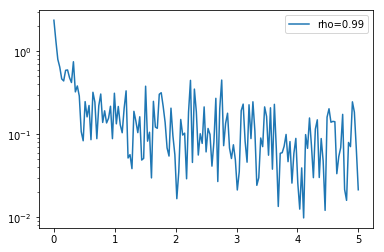

In [9]:
x_axis = np.linspace(0, 5, len(losses), endpoint=True)
plt.semilogy(x_axis, losses, label='rho=0.99')
plt.legend(loc='best')

## torch自带Adadelta优化函数

In [15]:
train_data=DataLoader(train_set,batch_size=64, shuffle=True)

net=nn.Sequential(nn.Linear(784,200),
                 nn.ReLU(),
                 nn.Linear(200,10))

optimizer=torch.optim.Adadelta(net.parameters(),rho=0.9)

start=time.time()

for e in range(5):
    train_loss=0
    for im,label in train_data:
        out=net(Variable(im))
        loss=criterion(out,Variable(label))
        
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
        
        train_loss+=loss.item()
    print('epoch:{},loss:{:.5f}'.format(e,loss.item()))
print('Used {:.5f}s'.format(time.time()-start))

epoch:0,loss:0.31295
epoch:1,loss:0.10840
epoch:2,loss:0.20857
epoch:3,loss:0.10646
epoch:4,loss:0.05195
Used 29.61564s
